In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import tree
import graphviz
from sklearn.metrics import accuracy_score 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,roc_curve,roc_auc_score,auc
import seaborn
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import shap

In [2]:
ds = pd.read_csv("raw_dataset.csv",header=1)
ds.head()

Code  Code-to subtype                        Ssample ID Source  Latitude  \
0     1              123                   PETDB-3513-V450  PetDB  -34.4630   
1     1              123  ODP0352-U1440B-012R-001W/128-129  PetDB   28.4625   
2     1              123  ODP0352-U1440B-012R-001W/082-086  PetDB   28.4625   
3     1              123  ODP0352-U1440B-012R-002W/020-024  PetDB   28.4625   
4     1              123  ODP0352-U1440B-012R-002W/041-044  PetDB   28.4625   

   Longitude Tectonic Setting Analyzed material      Ti        Pb  ...  \
0    177.823     VOLCANIC_ARC             GLASS  4544.0  4.170000  ...   
1    142.754     VOLCANIC_ARC        WHOLE ROCK  3433.0  0.072866  ...   
2    142.754     VOLCANIC_ARC        WHOLE ROCK  3357.0  0.070316  ...   
3    142.754     VOLCANIC_ARC        WHOLE ROCK  3424.0  0.068868  ...   
4    142.754     VOLCANIC_ARC        WHOLE ROCK  3476.0  0.068502  ...   

       Ce      Y      Nd  (La/Sm)PM     Sm       V     Dy     Tb      La  \
0  46.500  20.70  28.100   2.085795  6.290  321.00  3.790  0.714  20.300   
1   3.035  15.38   3.058   0.522852  1.199  268.30  2.592  0.362   0.970   
2   3.061  15.71   3.096   0.520334  1.252  277.70  2.741  0.375   1.008   
3   2.997  15.13   3.056   0.519367  1.217  276.98  2.586  0.360   0.978   
4   3.063  15.30   3.040   0.539464  1.210  273.84  2.559  0.365   1.010   

      Gd  
0  5.360  
1  1.958  
2  1.936  
3  1.838  
4  1.863  

[5 rows x 44 columns]

In [3]:
feature_list = list(ds.columns)
feature_list = feature_list[8:]
feature_list

['Ti',
 'Pb',
 'Sr',
 '(Nb/La)PM',
 'Zr/Y',
 '(Sm/Yb)PM',
 'Th/Yb',
 'Nb/Yb',
 'Ta/Yb',
 'Nb',
 'Eu',
 '(Ta/La)PM',
 'Yb',
 'U',
 'Ta',
 'Th',
 'Ba',
 'Rb',
 'Lu',
 'Zr',
 'Pr',
 'Sc',
 'Ho',
 'Cr',
 'Er',
 'Ni',
 'Ce',
 'Y',
 'Nd',
 '(La/Sm)PM',
 'Sm',
 'V',
 'Dy',
 'Tb',
 'La',
 'Gd']

In [4]:
x, features = ds[feature_list],ds[feature_list]
label = ds["Code"]
y = ds["Code"]
y

0       1
1       1
2       1
3       1
4       1
       ..
1406    2
1407    2
1408    2
1409    2
1410    2
Name: Code, Length: 1411, dtype: int64

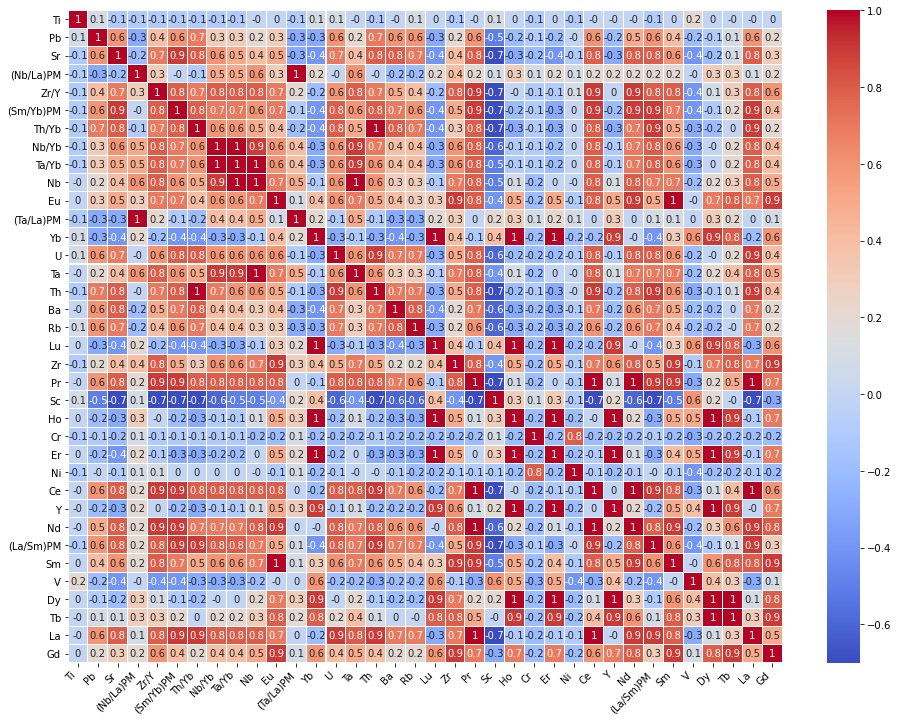

In [5]:
#计算特征相关系数，并绘制相关系数矩阵
fig,ax = plt.subplots(figsize = (16,12))
correlation_mat = features.corr().round(1)
cor_heat_map = seaborn.heatmap(correlation_mat,cmap = "coolwarm", annot=True,
                              linewidths=0.02,linecolor="White")
#plt.title("Heatmap of the correlation matrix",fontsize = 22)
plt.xticks(rotation=45,horizontalalignment="right")
#plt.savefig("correlation matrix.jpg", dpi=600)
plt.show()


In [6]:
model_rf = RandomForestClassifier(
    n_estimators=10,
    criterion='entropy',
    max_depth=10,
    bootstrap=True,
    n_jobs=-1,
    random_state=0,
    verbose=0,
)

In [7]:
from sklearn.preprocessing import StandardScaler

# Create a scaler object
scaler = StandardScaler()
# Fit the inputs (calculate the mean and standard deviation feature-wise)
scaler.fit(features)

x = scaler.transform(features)

print(x.shape)
print(y.shape)

print(type(x))
print(type(y))

(1411, 36)
(1411,)
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>


In [10]:
print(x.shape)
print(y.shape)

print(type(x))
print(type(y))

#y = y.to_numpy ()
#x = x.to_numpy ()
print(type(y))

(1411, 36)
(1411,)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [11]:
cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
results = pd.DataFrame(columns=['training_score', 'test_score'])
scores = []


for (train, test), i in zip(cv.split(x, y), range(5)):
    #model_rf.fit(features.iloc[train], label.iloc[train])
    model_rf.fit(x[train], y[train])
    train_score, test_score = model_rf.score(x[train], y[train]), model_rf.score(x[test], y[test])
    scores.append((train_score, test_score))
    
pd.DataFrame(scores, columns=['Train score', 'Test score'])



Train score  Test score
0     0.997340    0.971731
1     0.996457    0.971631
2     0.998229    0.985816
3     0.999114    0.982270
4     0.999114    0.982270

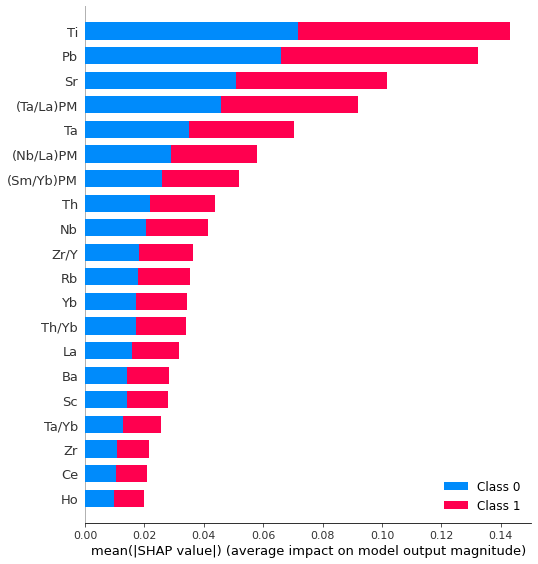

In [12]:
# cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
explainer = shap.TreeExplainer(model_rf)
shap_values = explainer.shap_values(x)

# for (train, test), i in zip(cv.split(features, label), range(5)):
#     model_rf.fit(features[train], label[train])
#     shap_values = explainer.shap_values(features[train])

shap.summary_plot(shap_values, x,plot_type="bar",feature_names = feature_list)

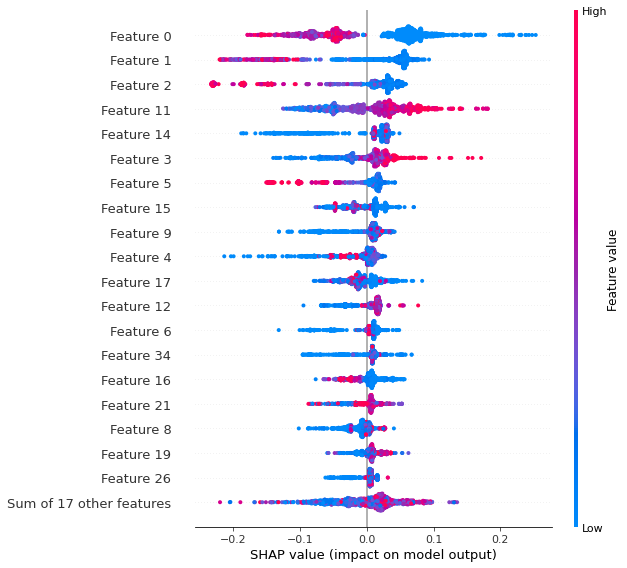

In [13]:
import copy

shap_values1 = explainer(x)
shap_values2 = copy.deepcopy(shap_values1)
shap_values2.values = shap_values2.values[:,:,1]
shap_values2.base_values = shap_values2.base_values[:,1]

shap.plots.beeswarm(shap_values2, max_display=20)

Text(0.5, 0, 'Random Forest Feature Importance')

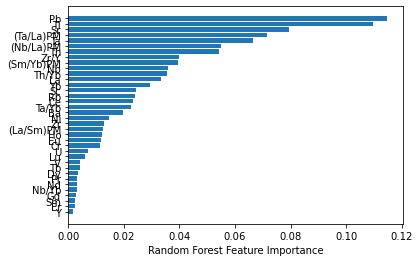

In [19]:
model_rf.feature_importances_

sorted_idx = model_rf.feature_importances_.argsort()
plt.barh(features.columns[sorted_idx], model_rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

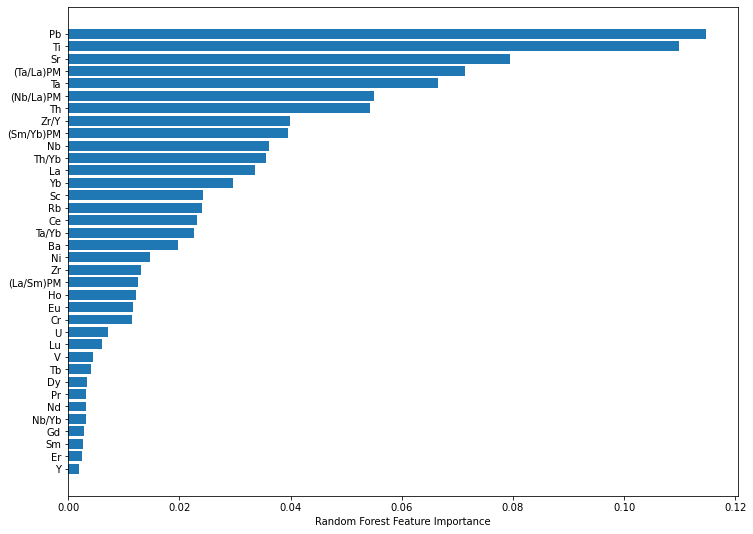

In [20]:
fig, ax = plt.subplots(figsize=(12, 9))

ax.barh(features.columns[sorted_idx], model_rf.feature_importances_[sorted_idx])

plt.xlabel("Random Forest Feature Importance")
plt.savefig("Feature importance.jpg", dpi=600)
plt.show()

In [20]:
def tree_viz(n):
    estimator = model_rf
    dot_data = model_rf.export_graphviz(model_rf,feature_names=feature_list,class_names=["1","2"],filled=True,rounded=True,out_file='tree.dot')
    graph = graphviz.Source(dot_data)
    return graph
#n表示随机森林中的第n棵树，按照最佳模型来说，一共有7棵树
#如下输出第2棵树的具体分类情况
tree_viz(1)

AttributeError: 'RandomForestClassifier' object has no attribute 'export_graphviz'

In [58]:
forest_prob = model_rf.predict_proba(x_test)[:,1]
importances = pd.DataFrame(model_rf.feature_importances_, index=feature_list, columns=['importance'])

def forest_insight(x_val, y_val, thr, forest_prob, importances, nfeat):

    dec = map(lambda x: (x> thr)*1,forest_prob)
    val_c = x_val.copy()

#     #scale features for visualization
#     val_c = pandas.DataFrame(StandardScaler().fit_transform(val_c), columns=X_val.columns)

    val_c = val_c[importances.sort('importance', ascending=False).index[0:nfeat]]
    val_c['t']=y_val
    val_c['p']=dec
    val_c['err']=np.NAN

    val_c.loc[(val_c['t']==0)&(val_c['p']==1),'err'] = 3#'fp'
    val_c.loc[(val_c['t']==0)&(val_c['p']==0),'err'] = 2#'tn'
    val_c.loc[(val_c['t']==1)&(val_c['p']==1),'err'] = 1#'tp'
    val_c.loc[(val_c['t']==1)&(val_c['p']==0),'err'] = 4#'fn'

    n_fp = len(val_c.loc[(val_c['t']==0)&(val_c['p']==1),'err'])
    n_tn = len(val_c.loc[(val_c['t']==0)&(val_c['p']==0),'err'])
    n_tp = len(val_c.loc[(val_c['t']==1)&(val_c['p']==1),'err'])
    n_fn = len(val_c.loc[(val_c['t']==1)&(val_c['p']==0),'err'])

    fp = np.round(val_c[(val_c['t']==0)&(val_c['p']==1)].mean(),2)
    tn = np.round(val_c[(val_c['t']==0)&(val_c['p']==0)].mean(),2)
    tp =  np.round(val_c[(val_c['t']==1)&(val_c['p']==1)].mean(),2)
    fn =  np.round(val_c[(val_c['t']==1)&(val_c['p']==0)].mean(),2)


    c = pd.concat([tp,fp,tn,fn],names=['tp','fp','tn','fn'],axis=1)
    pd.set_option('display.max_colwidth',900)
    c = c[0:-3]

    c.columns = ['TP','FP','TN','FN']
    return c

In [12]:
import plotly.express as px
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
components = pca.fit_transform(features)

fig = px.scatter(components, x=0, y=1, color=ds['Code'])
fig.show()

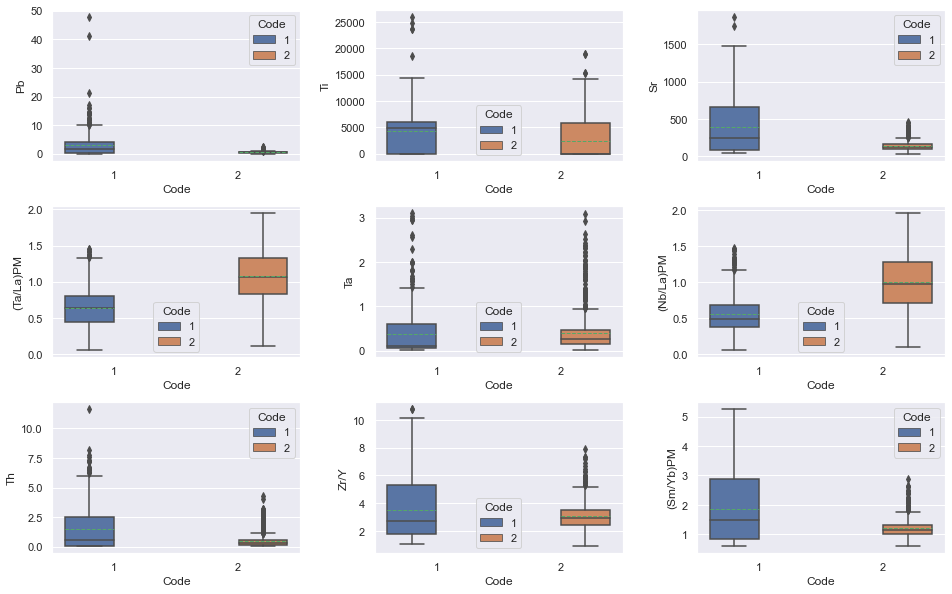

In [21]:
import seaborn as sns


sns.set()
fig = plt.figure(figsize=(16,10)) # 这里的画布大小还是先设置好吧。
for i in range(9):
    # 遍历每张子图
    ax = fig.add_subplot(3, 3, i + 1)
    sns.boxplot(x=ds["Code"], y=features.columns[sorted_idx][::-1][i], hue=ds["Code"], data=ds, ax=ax, meanline=True, showmeans=True, )
    # 单独设置了每个子图的标题， 为了方便查看， 也可以省略
    #ax.set_title(lst[i]+'_index_contrast')
    # 设置子图之间的横纵边距， 不然会挤到一块， 影响阅读
    plt.subplots_adjust(wspace=0.3,hspace=0.3)


Confusion matrix, without normalization
[[ 91   6]
 [  2 184]]
Normalized confusion matrix
[[0.93814433 0.06185567]
 [0.01075269 0.98924731]]
Confusion matrix, without normalization
[[ 91   6]
 [  2 183]]
Normalized confusion matrix
[[0.93814433 0.06185567]
 [0.01081081 0.98918919]]
Confusion matrix, without normalization
[[ 92   4]
 [  0 186]]
Normalized confusion matrix
[[0.95833333 0.04166667]
 [0.         1.        ]]
Confusion matrix, without normalization
[[ 92   4]
 [  1 185]]
Normalized confusion matrix
[[0.95833333 0.04166667]
 [0.00537634 0.99462366]]
Confusion matrix, without normalization
[[ 92   4]
 [  1 185]]
Normalized confusion matrix
[[0.95833333 0.04166667]
 [0.00537634 0.99462366]]


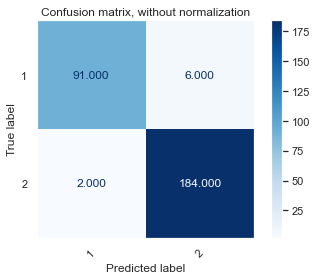

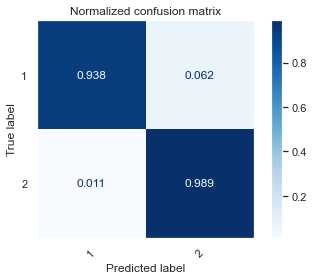

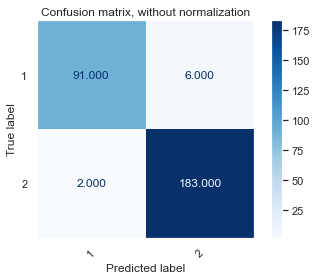

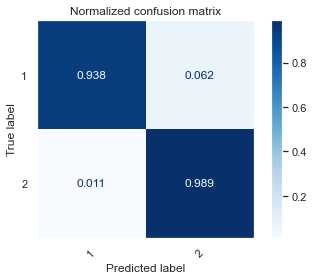

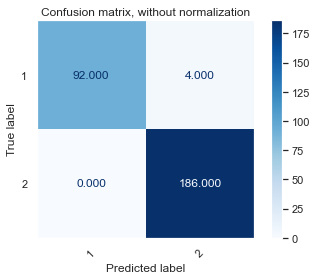

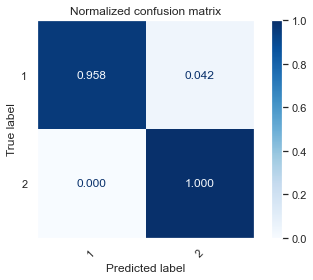

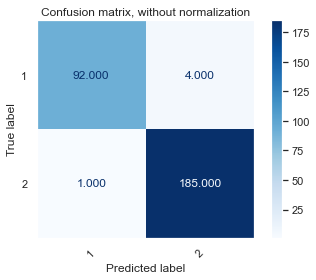

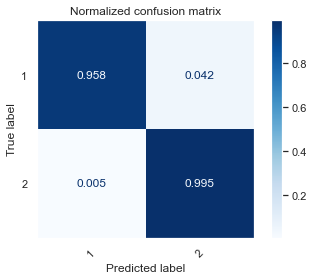

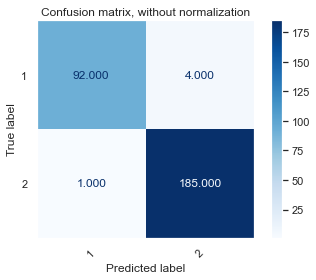

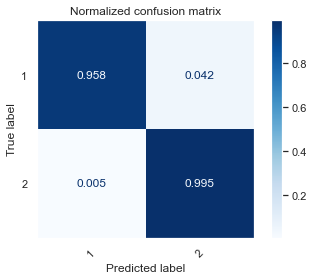

In [22]:
from sklearn.metrics import plot_confusion_matrix

titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]


for (train, test), i in zip(cv.split(x, y), range(5)):
    #model_rf.fit(features.iloc[train], label.iloc[train])
    model_rf.fit(x[train], y[train])

    for title, normalize in titles_options:
        disp = plot_confusion_matrix(model_rf, x[test], y[test],
                                     display_labels=['1','2'],
                                     cmap=plt.cm.Blues,
                                     normalize=normalize,
                                     values_format='.3f')
        disp.ax_.set_title(title)
        plt.xticks(rotation=45)
        print(title)
        print(disp.confusion_matrix)
        
        plt.grid(False)
        
#plt.savefig("Confusion matrix.jpg", dpi=600)
plt.show()

        
    #plt.savefig('ori',dpi=600, bbox_inches='tight')
#     plt.grid(False)
#     plt.savefig("Confusion matrix.jpg", dpi=600)
#     plt.show()

In [25]:
new_pred_ds = pd.read_csv("new_pred_ds.csv")

new_pred_ds.head()

La    Ce      Pr     Nd    Sm     Eu    Gd     Tb    Dy     Ho  ...  \
0  34.9  84.1  10.760  44.28  9.43  2.882  8.38  1.232  6.94  1.379  ...   
1  33.1  70.3   9.027  36.98  7.66  2.394  6.80  0.979  5.49  1.088  ...   
2  39.2  79.2   9.170  34.60  5.95  1.500  4.77  0.660  3.74  0.720  ...   
3  39.9  79.8   9.250  34.00  5.74  1.400  4.73  0.640  3.60  0.700  ...   
4  36.2  73.1   8.450  32.10  5.54  1.440  4.53  0.620  3.54  0.680  ...   

      Y     Zr      Zr/Y     Ta/Yb     Th/Yb      Nb/Yb  (La/Sm)PM  (Sm/Yb)PM  \
0  37.7  285.0  7.559682  1.517647  1.956656  24.055728   2.391883   3.241702   
1  28.8  240.0  8.333333  1.653150  2.145669  26.220472   2.792708   3.348567   
2  19.3  102.0  5.284974  0.217143  3.857143   4.285714   4.257899   3.775225   
3  19.1   93.0  4.869110  0.209581  4.053892   4.011976   4.492491   3.816448   
4  18.6   91.0  4.892473  0.201220  3.658537   3.963415   4.223038   3.750851   

   (Nb/La)PM  (Ta/La)PM  
0   2.145175   2.353536  
1   1.938713   2.125645  
2   0.184350   0.162432  
3   0.161796   0.146983  
4   0.173010   0.152749  

[5 rows x 36 columns]

In [26]:
pred = model_rf.predict(new_pred_ds)

pred.reshape(-1)
pred

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 3, 3, 3, 1, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], dtype=int64)